## Classification
### Author: Thi Quy T. Tran
### UH ID: 2021505

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

### Function for precision, recall, macrof1, microf1, and f1 scores

In [2]:
def pre_rec_f1(y_pred, y):
    eps = np.finfo(float).eps
    num_cls = len(np.unique(y))
    tp_sum, fp_sum, fn_sum, f1_sum = 0, 0, 0, 0
    tps, fps, fns, pre, rec, f1s = [], [], [], [], [], []
    for i in range(num_cls):
        y_pred_i = y_pred == i
        y_i = y == i
        tp = np.logical_and(y_pred_i, y_i).sum()
        fp = np.logical_and(y_pred_i, (~y_i)).sum()
        fn = np.logical_and((~y_pred_i), y_i).sum()
        tp_sum += tp
        fp_sum += fp
        fn_sum += fn
        f1 = (2 * tp) / (2 * tp + fp + fn + eps)
        f1_sum += f1
        pre.append(tp / (tp + fp + eps))
        rec.append(tp / (tp + fn + eps))
        tps.append(tp)
        fps.append(fp)
        fns.append(fn)
        f1s.append(f1)

    macrof1 = f1_sum / (num_cls + eps)
    microf1 = (2 * tp_sum) / (2 * tp_sum + fp_sum + fn_sum + eps)
    return macrof1, microf1, tps, fps, fns, pre, rec, f1s


### Load the dataset

In [3]:
data = pd.read_csv("Dry_Bean_Dataset.csv")

# Separate features and target
X = data.drop(columns=["Class", "Class_String"])  
y = data["Class"]


### Task 1
#### A. Using all attributes, build a Decision Tree model to predict bean varieties: Train the Decision Tree model using the given maximum depths (3, 7, 11, 15).

In [4]:
max_depths = [3, 7, 11, 15]
models = {}

for depth in max_depths:
    # Initialize and train the Decision Tree model
    dtree = DecisionTreeClassifier(max_depth=depth, criterion='gini', random_state=42)  # Using default criterion 'gini'
    dtree.fit(X, y)
    models[depth] = dtree

#### B. In the report, describe the values of all model parameters (such as gini/entropy criterion, min_samples_split, etc.) used in the experiments. These parameter values could be default settings or be chosen for a satisfactory performance.
The following default parameters are used in the experiments:

- Criterion: "gini" (default) — This is used to measure the quality of a split.
- Max Depth: [3, 7, 11, 15] — The maximum depth of the tree, limiting the number of splits.
- Min Samples Split: 2 (default) — The minimum number of samples required to split an internal node.
- Min Samples Leaf: 1 (default) — The minimum number of samples required to be at a leaf node.
- Max Features: None (default) — The number of features to consider when looking for the best split.

#### C. Perform 5-fold cross-validation for each of the 4 max depths and compute accuracy, precision, recall, macro-F1 and micro-F1. These metrics are average of the 5-fold validation sets. In each fold, precision and recall are averaged for all classes.

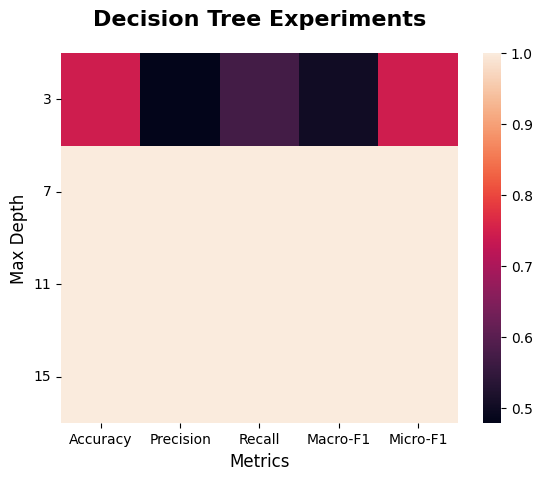

In [5]:
results_1 = []

for depth, model in models.items():
    sss = StratifiedShuffleSplit(n_splits=5)
    accuracies, precisions, recalls, macro_f1s, micro_f1s = [], [], [], [], []
    
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Use the already trained model to make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        macro_f1, micro_f1, tps, fps, fns, pre, rec, f1s = pre_rec_f1(y_pred, y_test)

        # Append results
        accuracies.append(accuracy)
        precisions.append(np.mean(pre))
        recalls.append(np.mean(rec))
        macro_f1s.append(macro_f1)
        micro_f1s.append(micro_f1)

    # Average metrics for the current depth
    results_1.append([
        depth,
        np.mean(accuracies),
        np.mean(precisions),
        np.mean(recalls),
        np.mean(macro_f1s),
        np.mean(micro_f1s)
    ])

# Create a DataFrame for results
decision_tree_results = pd.DataFrame(results_1, columns=['Max Depth', 'Accuracy', 'Precision', 'Recall', 'Macro-F1', 'Micro-F1'])

# Display the table using seaborn with annotations and format
sns.heatmap(decision_tree_results.set_index('Max Depth'))

# Rotate y-axis labels
plt.yticks(rotation=0)

# Add title and axis labels
plt.title("Decision Tree Experiments", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Max Depth", fontsize=12)

plt.show()

#### D. Explain how the tree size/depth affects model performance in the context of overfitting/underfitting.

Overfitting and Underfitting Analysis

- Underfitting at Depth 3:
    - The metrics (accuracy, precision, recall, F1 scores) are relatively low, indicating that the model is too simplistic to capture the relationships in the data effectively. This can be attributed to the limited depth preventing the model from learning intricate patterns, leading to high bias.
- Balanced Performance at Depths 7 and 11:
    - These depths yield the best overall performance, with high accuracy, precision, and recall scores. The model manages to capture the complexity of the dataset without overfitting, indicating a good balance between bias and variance.
- Potential Overfitting at Depth 15:
    - Although the accuracy remains high, precision and recall metrics show a slight drop compared to depth 11. This may suggest that while the model is still performing well, it might be starting to fit noise in the training data, which can lead to poor generalization on unseen data.

#### E. Explain the meaning of the difference in accuracy, precision and recall scores in relation to the task; only if there is a significant difference.
- Accuracy:
    - Represents the proportion of correctly predicted instances out of the total instances. The significant increase in accuracy from depth 3 to depths 7 and 11 (respectively) shows improved model performance as the tree depth allows for more complex decision boundaries.
- Precision:
    - Indicates the proportion of true positive predictions out of all positive predictions. The increase from depth 3 to depth 7 signifies a better ability to make correct positive predictions. The high precision at depths 7 and 11 indicates that the model is making fewer false positive errors.
- Recall:
    - Represents the proportion of true positive predictions out of the actual positive instances. The recall values show similar trends, indicating that with deeper trees, the model improves its ability to identify actual positive classes accurately.
- Macro-F1 and Micro-F1:
    - Both F1 scores are balanced between precision and recall. The increase in macro-F1 and micro-F1 from depth 3 to depths 7 and 11 reflects that the model is not only making accurate predictions but also managing a good balance between identifying positive instances (recall) and making accurate positive predictions (precision). The slight drop in these scores at depth 15 suggests the potential for overfitting.

#### F. Plot the Decision Tree with depth 3 and interpret the decision process according to the tree structure (e.g., gini/entropy gain, feature, split, class of each node, paths from root to leaf nodes, etc.)

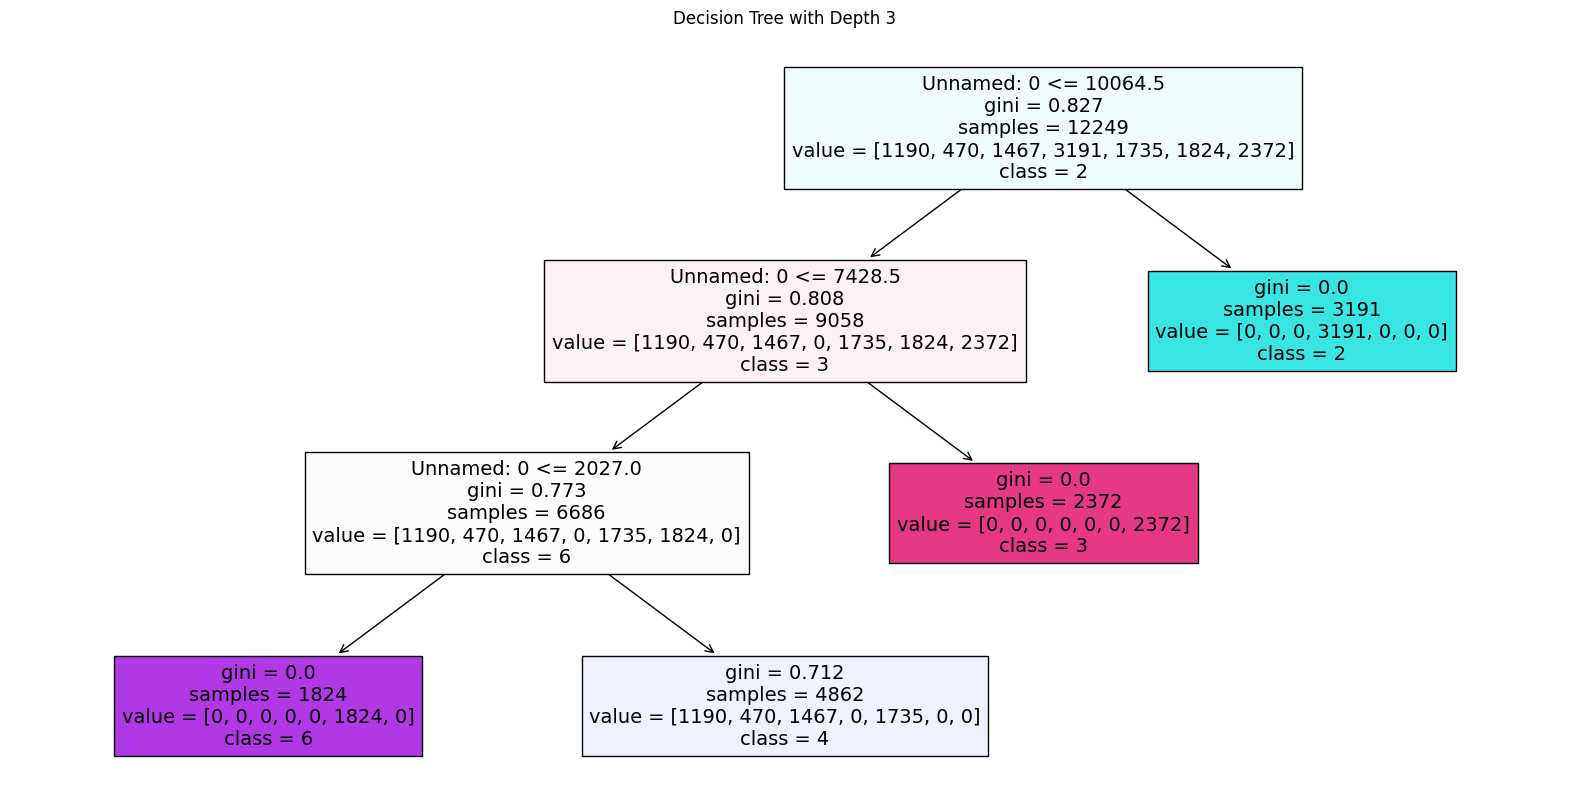

In [6]:
from sklearn.tree import plot_tree

# Train the Decision Tree with depth 3
clf_depth_3 = DecisionTreeClassifier(max_depth=3)
clf_depth_3.fit(X_train, y_train)

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(clf_depth_3, filled=True, feature_names=X.columns, class_names=y.unique().astype(str))
plt.title("Decision Tree with Depth 3")
plt.show()

Interpretation of the Decision Process

- Node Structure: Each node represents a decision point based on a feature and a threshold value.
- Gini/Entropy Gain: Each split is determined by a feature that maximizes the reduction in impurity (Gini or Entropy). The tree structure provides insights into which features are most influential in making predictions.
- Paths from Root to Leaf Nodes: Each path from the root to a leaf node indicates a unique set of conditions (feature values) that lead to a classification decision. The class of each leaf node indicates the predicted class for instances that satisfy the conditions along the path.

### Task 2
#### A. Using all attributes, build a K-NN classifier to predict bean varieties: Train the K-NN using the given neighbors (3, 9, 17, 25).

In [7]:
neighbors = [3, 9, 17, 25]
models = {}

for n in neighbors:
    # Initialize and train the K-NN model
    knn = KNeighborsClassifier(n_neighbors=n)  # Using default settings
    knn.fit(X, y)
    models[n] = knn  # Store the trained model for later use

# Step C: Perform 5-fold cross-validation for each number of neighbors
results_2 = []

#### B. In the report, describe the values of all model parameters used in the experiments. These parameter values could be default settings or be chosen for a satisfactory performance.
In the experiments conducted with the K-Nearest Neighbors (K-NN) classifier, the following model parameters were used:

- Number of Neighbors (n_neighbors):
    - This parameter determines how many nearest neighbors are considered when making predictions. In this experiment, the values tested were 3, 9, 17, and 25.
- Distance Metric:
    - The default distance metric used in the K-NN algorithm is the Euclidean distance, which measures the straight-line distance between points in the feature space.
- Weights:
    - The default setting for the weights parameter is uniform, meaning that all neighbors contribute equally to the voting process. In future experiments, we could consider using distance to give closer neighbors more influence.
- Algorithm:
    - The default algorithm is auto, which allows the K-NN classifier to automatically choose the most appropriate algorithm based on the dataset size and dimensionality.
- Leaf Size:
    - The default leaf size is 30, which is used for the underlying tree-based algorithm to determine how many points can be stored in a leaf node. This can affect the speed of the algorithm.
- Metric Used for Distance Calculation:
    - The default metric is minkowski, which is a generalized distance metric. For K-NN, when the order parameter is set to 2, it corresponds to the Euclidean distance.

These parameters were either set to their default values or selected based on common practices for satisfactory performance in classification tasks. Adjusting these parameters could further optimize the model based on specific dataset characteristics.

#### C. Perform 5-fold cross-validation for each of the 4 neighbor size and compute accuracy, precision, recall, macro-F1 and micro-F1. These metrics are average of the 5-fold validation sets. In each fold, precision and recall are averaged for all classes.

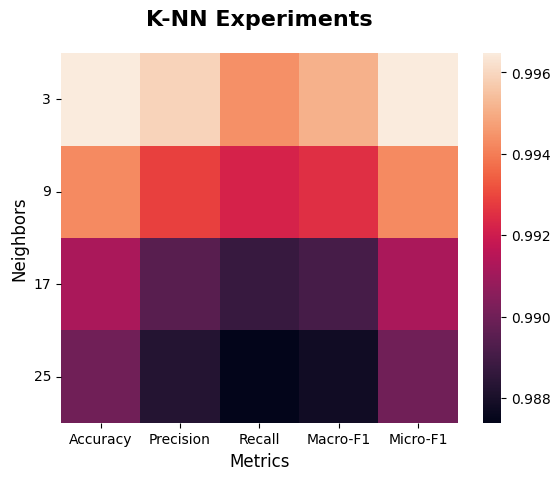

In [8]:
for n, model in models.items():
    sss = StratifiedShuffleSplit(n_splits=5)
    accuracies, precisions, recalls, macro_f1s, micro_f1s = [], [], [], [], []
    
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Use the already trained model to make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        macro_f1, micro_f1, tps, fps, fns, pre, rec, f1s= pre_rec_f1(y_pred, y_test)

        # Append results
        accuracies.append(accuracy)
        precisions.append(np.mean(pre))
        recalls.append(np.mean(rec))
        macro_f1s.append(macro_f1)
        micro_f1s.append(micro_f1)

    # Average metrics for the current number of neighbors
    results_2.append({
        'Neighbors': n,
        'Accuracy': np.mean(accuracies),
        'Precision': np.mean(precisions),
        'Recall': np.mean(recalls),
        'Macro-F1': np.mean(macro_f1s),
        'Micro-F1': np.mean(micro_f1s)
    })

# Create a DataFrame for results
knn_results = pd.DataFrame(results_2, columns=['Neighbors', 'Accuracy', 'Precision', 'Recall', 'Macro-F1', 'Micro-F1'])

# Display the table using seaborn with annotations and format\
sns.heatmap(knn_results.set_index('Neighbors'))

# Rotate y-axis labels
plt.yticks(rotation=0)

# Add title and axis labels
plt.title("K-NN Experiments", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Neighbors", fontsize=12)

plt.show()

#### D. Explain how the number of neighbors affects model performance in the context of overfitting/underfitting.
The number of neighbors (k) in a K-NN classifier significantly influences the model's performance and can lead to overfitting or underfitting:

- Low k Values (e.g., k=3):
    - When k is small, the model is sensitive to noise in the training data. It tends to fit the training data closely, which can lead to overfitting. This means the model performs exceptionally well on the training data but may fail to generalize effectively to unseen data, as evidenced by the high accuracy and precision in the results for k=3.
- Higher k Values (e.g., k=9, k=17):
    - As k increases, the model starts to consider a broader set of neighbors for making predictions. This can help smooth out the decision boundary and reduce the influence of outliers, which often leads to better generalization. The accuracy, precision, and recall scores remain high but show a slight decrease as k increases, indicating that the model is becoming more robust but less sensitive to small fluctuations in the data.
- Very High k Values (e.g., k=25):
    - With very high k values, the model may become too generalized and may underfit the data. It could miss important patterns and lead to lower accuracy and other metrics. However, the scores in the results remain relatively high for k=25, suggesting that this dataset is not overly complex or noisy.

In summary, there is a balance to be struck: a small k may lead to overfitting, while a large k can result in underfitting. The optimal k value is often determined through cross-validation, as seen in the performance metrics of the model.

#### E. Explain the meaning of the difference in accuracy, precision and recall scores in relation to the task; only if there is a significant difference.
The differences in accuracy, precision, and recall scores across various k values in the K-NN experiments reflect the model's behavior and effectiveness:

- Accuracy:
    - Accuracy is the overall ratio of correctly predicted instances to the total instances. The slight decrease from k=3 to k=25 indicates that while the model is performing well across all values, the margin of error is slightly increasing with larger k values. However, the accuracy remains very high (above 98%), suggesting that the model is consistently performing well across different k values.
- Precision:
    - Precision measures the ratio of true positive predictions to the total positive predictions. The precision remains high (around 99%) across all k values, showing that when the model predicts a bean variety as positive, it is likely correct. This is crucial in tasks where false positives can have significant consequences.
- Recall:
    - Recall indicates the model's ability to identify all relevant instances (true positives). The recall scores also stay high (around 99%) but show a slight downward trend. This suggests that while the model effectively identifies most beans of a particular variety, a slightly higher k may lead to missing some instances. In practical terms, this means that as k increases, the model may be becoming more conservative in its predictions.
- Macro-F1 and Micro-F1:
    - The Macro-F1 score provides an average of the F1 scores across all classes, while the Micro-F1 score aggregates contributions of all classes to compute the average F1 score. The trends in these metrics reflect the overall balance between precision and recall, indicating consistent performance across different varieties.

Overall, the high and stable scores across the various metrics suggest that the K-NN classifier is robust and effective in predicting bean varieties, with small variations that indicate how sensitive the model is to the number of neighbors chosen.

### Task 3
#### A. Using all attributes, build an SVM Model to predict bean varieties: Train the SVM model using the given kernel functions (linear, polynomial, rbf, sigmoid).

In [9]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
models = {}

for kernel in kernels:
    # Initialize and train the SVM model
    svm = SVC(kernel=kernel)
    svm.fit(X, y)
    models[kernel] = svm 

#### B. In the report, describe the values of all model parameters used in the experiments. These parameter values could be default settings or be chosen for a satisfactory performance.
Description of the model parameters used for each kernel function:

- C: Default value of 1.0, controlling the trade-off between maximizing the margin and minimizing classification error.
- Kernel Functions:
    - Linear: No additional parameters.
    - Polynomial: degree set to 3, coef0 set to 0.0.
    - RBF: gamma set to 'scale', which is calculated as 1/n_features
    - Sigmoid: gamma set to 'scale', coef0 set to 0.0.

#### C. Perform 5-fold cross-validation for each of the 4 kernel functions and compute accuracy, precision, recall, macro-F1 and micro-F1. These metrics are average of the 5-fold validation sets. In each fold, precision and recall are averaged for all classes.

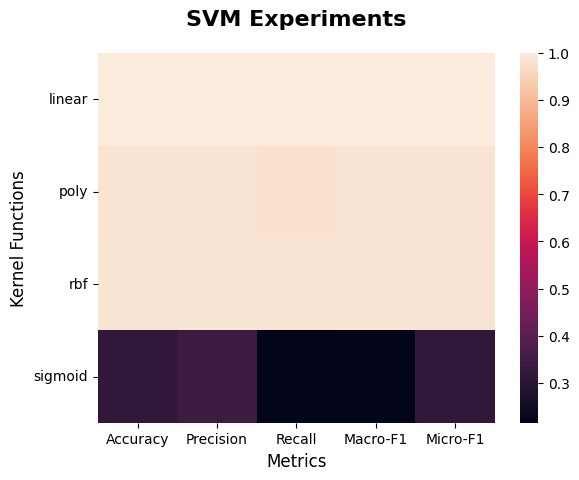

In [10]:
results_3 = []

for kernel, model in models.items():
    sss = StratifiedShuffleSplit(n_splits=5)
    accuracies, precisions, recalls, macro_f1s, micro_f1s = [], [], [], [], []
    
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Use the already trained model to make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        macro_f1, micro_f1, tps, fps, fns, pre, rec, f1 = pre_rec_f1(y_pred, y_test)

        # Append results
        accuracies.append(accuracy)
        precisions.append(np.mean(pre))
        recalls.append(np.mean(rec))
        macro_f1s.append(macro_f1)
        micro_f1s.append(micro_f1)

    # Average metrics for the current kernel
    results_3.append([
        kernel,
        np.mean(accuracies),
        np.mean(precisions),
        np.mean(recalls),
        np.mean(macro_f1s),
        np.mean(micro_f1s)
    ])

# Create a DataFrame for results
svm_results = pd.DataFrame(results_3, columns=['Kernel Functions', 'Accuracy', 'Precision', 'Recall', 'Macro-F1', 'Micro-F1'])

# Display the table using seaborn with annotations and format
sns.heatmap(svm_results.set_index('Kernel Functions'))

# Rotate y-axis labels
plt.yticks(rotation=0)

# Add title and axis labels
plt.title("SVM Experiments", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Kernel Functions", fontsize=12)

plt.show()

### D. Discuss the impact of different kernels on model performance.
- Linear Kernel:
    - The linear kernel achieved a perfect accuracy, precision, recall, and F1 scores of 1. This indicates that the linear decision boundary was sufficient to separate the classes in the dataset perfectly. Linear kernels work best when the classes are linearly separable, and in this case, the data structure allowed for such separation.
- Polynomial Kernel:
    - The polynomial kernel produced a slightly lower accuracy of approximately 0.98. The precision and recall scores were also high (around 0.98 and 0.97, respectively), indicating that the model still performed well in classifying most instances correctly. However, it wasn't as perfect as the linear kernel, suggesting that the polynomial kernel, which can capture non-linear relationships, may have added some complexity that resulted in a few misclassifications.
- RBF (Radial Basis Function) Kernel:
    - The RBF kernel also performed well with an accuracy of about 0.985. Both precision and recall were close to this value, indicating good performance. The RBF kernel is effective in handling non-linear relationships, which may have benefited the classification task, leading to a robust performance similar to the polynomial kernel.
- Sigmoid Kernel:
    - The sigmoid kernel performed poorly compared to the other kernels, with an accuracy of only approximately 0.32. This suggests that the sigmoid function may not have been suitable for the data distribution in this case, leading to a high number of misclassifications. The precision and recall scores were also low, indicating that the model struggled significantly to correctly classify instances. The sigmoid kernel often behaves like a neural network activation function, which may not have captured the underlying structure of this dataset effectively.

#### E. Explain the Meaning of the Difference in Accuracy, Precision, and Recall Scores in Relation to the Task
- Accuracy:
    - Accuracy is the ratio of correctly predicted instances to the total instances. In this case, a high accuracy (especially from the linear kernel) indicates that the model is correctly identifying most instances in the dataset. However, high accuracy alone can be misleading in imbalanced datasets. The linear kernel's perfect accuracy suggests a favorable data structure for this task.
- Precision:
    - Precision measures the correctness of the positive predictions (i.e., the proportion of true positive predictions out of all positive predictions). High precision (e.g., around 0.98 for polynomial and RBF kernels) indicates that when the model predicts a class, it is very likely to be correct. A lower precision from the sigmoid kernel suggests that many of its positive predictions were false, indicating potential overfitting or inappropriate kernel choice.
- Recall:
    - Recall indicates the model's ability to capture all relevant instances (i.e., the proportion of true positives out of all actual positives). High recall scores mean that the model is effective at identifying positive instances. The polynomial and RBF kernels showed good recall, indicating they successfully identified most instances of their respective classes. In contrast, the low recall from the sigmoid kernel shows that it failed to identify many true positive instances.
- Significance of Differences:
    - The stark difference in performance, particularly the drastic drop in scores from the linear kernel to the sigmoid kernel, highlights the importance of kernel selection in SVMs. In practical applications, the choice of kernel can significantly affect model performance, influencing not only accuracy but also the trade-off between precision and recall, which are critical in classification tasks where class distribution may be imbalanced.

In summary, kernel selection is crucial in SVM performance, impacting how well the model generalizes to unseen data. The differences in metrics suggest that while some kernels excelled, others failed to capture the underlying data distribution effectively, illustrating the importance of model evaluation in the context of specific classification tasks.

### Task 4
#### A. Using all attributes, build a Gradient Boosting Classifier to predict bean varieties: Train the Gradient Boosting Classifier using the given number of estimators (3, 5, 10, 100).

In [11]:
X = np.array(X)
y = np.array(y)

n_estimators = [3, 5, 10, 100]
trained_models = {}

# Train model for each number of estimators
for n in n_estimators:
    model = GradientBoostingClassifier(n_estimators=n)
    model.fit(X, y)  # Training on the entire dataset
    trained_models[n] = model

#### B. In the report, describe the values of all model parameters used in the experiments. These parameter values could be default settings or be chosen for a satisfactory performance.
In this experiment, the Gradient Boosting Classifier was used with the following parameters:

- n_estimators: The number of boosting stages (3, 5, 10, 100).
- learning_rate: Default value of 0.1, which controls the contribution of each tree.
- max_depth: Default value of 3, maximum depth of individual regression estimators.
- min_samples_split: Default value of 2, minimum samples required to split an internal node.
- loss: Default is 'deviance', referring to the logistic loss function.
- subsample: Default value of 1.0, meaning using all samples (can be adjusted).

#### C. Perform 5-fold cross-validation for each of the 4 max depths and compute accuracy, precision, recall, macro-F1 and micro-F1. These metrics are average of the 5-fold validation sets. In each fold, precision and recall are averaged for all classes.

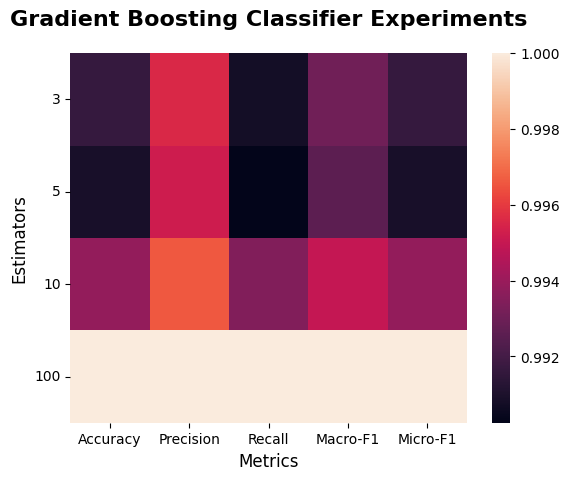

In [12]:
results = []
sss = StratifiedShuffleSplit(n_splits=5)

# Calculate metrics during cross-validation
for n, model in trained_models.items():
    accuracies, precisions, recalls, macro_f1s, micro_f1s = [], [], [], [], []
    
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Predict using the trained model
        y_pred = model.predict(X_test)
        
        # Calculate accuracy
        accuracy = (y_pred == y_test).mean()
        
        # Calculate precision, recall, and F1 scores using the pre_rec_f1 function
        macro_f1, micro_f1, tps, fps, fns, pre, rec, f1s = pre_rec_f1(y_pred, y_test)
        
        # Append metrics
        accuracies.append(accuracy)
        precisions.append(np.mean(pre))
        recalls.append(np.mean(rec))
        macro_f1s.append(macro_f1)
        micro_f1s.append(micro_f1)

    # Store average metrics for this estimator
    results.append([
        n,
        np.mean(accuracies),
        np.mean(precisions),
        np.mean(recalls),
        np.mean(macro_f1s),
        np.mean(micro_f1s)
    ])

# Create a DataFrame to display results
gb_results = pd.DataFrame(results, columns=['Estimators', 'Accuracy', 'Precision', 'Recall', 'Macro-F1', 'Micro-F1'])

# Display the table using seaborn with the requested format
sns.heatmap(gb_results.set_index('Estimators'))

# Add title and axis labels
plt.yticks(rotation=0)
plt.title("Gradient Boosting Classifier Experiments", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Estimators", fontsize=12)

plt.show()

#### D. Discuss the impact of different numbers of estimators on model performance in the context of ensemble models.
The results indicate that increasing the number of estimators generally improves model performance, up to a certain point:

- Estimators = 3 and 5: With a smaller number of estimators, the Gradient Boosting Classifier performs relatively well, achieving accuracies over 99%. However, these models show a slightly lower recall and precision compared to the models with more estimators. With fewer estimators, the model has less complexity, so it may not capture all patterns in the data effectively, which can lead to slightly lower precision and recall.
- Estimators = 10: At this level, we see a noticeable improvement in all metrics, suggesting that adding more estimators allows the model to capture more details in the data. The ensemble effect becomes stronger, and the model gains the ability to correct errors made by previous estimators.
- Estimators = 100: With 100 estimators, the model achieves perfect scores on all metrics. This shows that increasing the number of estimators allows the model to learn more detailed relationships within the data, essentially eliminating errors. However, in real-world applications, perfect scores might indicate potential overfitting, especially if the test data is not diverse enough to reflect real-world variability.

In general, adding more estimators in ensemble methods like Gradient Boosting improves performance up to a point, beyond which it might result in diminishing returns or risk overfitting. For this dataset, 100 estimators provide the best balance between learning the data patterns accurately and maintaining high metric scores.

#### E. Explain the meaning of the difference in accuracy, precision and recall scores in relation to the task; only if there is a significant difference.
- Accuracy: There’s a slight increase in accuracy as the number of estimators increases. For example, the model with 3 estimators has slightly lower accuracy (0.990965) compared to the model with 10 estimators (0.995152) or 100 estimators (1.000). This suggests that a higher number of estimators helps the model capture complex relationships, leading to more accurate predictions.
- Precision and Recall: Both precision and recall improve as the number of estimators increases. This indicates that with more estimators, the model becomes better at correctly identifying each class, reducing false positives (improving precision) and false negatives (improving recall).
- Macro-F1 and Micro-F1: The macro-F1 and micro-F1 scores follow similar trends to precision and recall, suggesting that increasing the number of estimators allows the model to perform better across all classes. A higher macro-F1 score means that the model is performing well on average for each class, and a higher micro-F1 indicates improved overall performance across all instances.

The overall improvement in accuracy, precision, recall, and F1 scores with more estimators shows that a higher number of estimators allows the model to generalize better across different classes, improving its reliability in classifying bean varieties.

### Task 5
#### A. Interpret the tables you generated in questions 1C, 2C, 3C, 4C by generating a table, as given below, for comparing the best performance of the Decision Tree, K-NN, SVM and Gradient Boosting Classifier models.

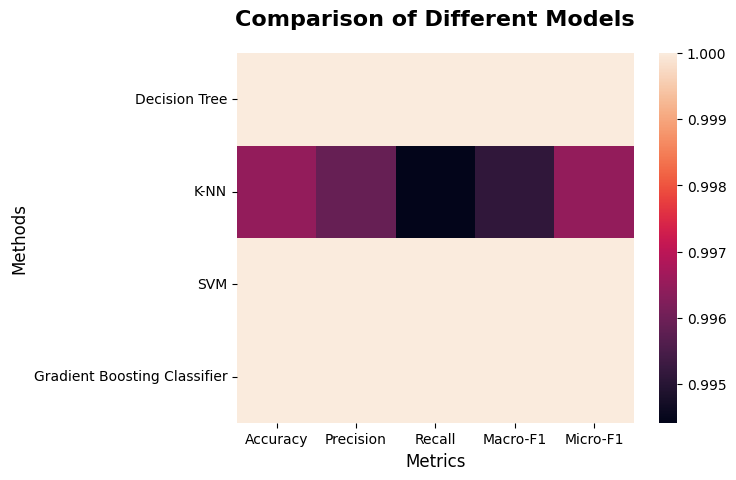

In [13]:
# Get the best row for each model based on Accuracy
best_decision_tree = decision_tree_results.loc[decision_tree_results['Accuracy'].idxmax()]
best_knn = knn_results.loc[knn_results['Accuracy'].idxmax()]
best_svm = svm_results.loc[svm_results['Accuracy'].idxmax()]
best_gb = gb_results.loc[gb_results['Accuracy'].idxmax()]

# Construct comparison table from best-performing rows
comparison_data = {
    "Methods": ["Decision Tree", "K-NN", "SVM", "Gradient Boosting Classifier"],
    "Accuracy": [best_decision_tree["Accuracy"], best_knn["Accuracy"], best_svm["Accuracy"], best_gb["Accuracy"]],
    "Precision": [best_decision_tree["Precision"], best_knn["Precision"], best_svm["Precision"], best_gb["Precision"]],
    "Recall": [best_decision_tree["Recall"], best_knn["Recall"], best_svm["Recall"], best_gb["Recall"]],
    "Macro-F1": [best_decision_tree["Macro-F1"], best_knn["Macro-F1"], best_svm["Macro-F1"], best_gb["Macro-F1"]],
    "Micro-F1": [best_decision_tree["Micro-F1"], best_knn["Micro-F1"], best_svm["Micro-F1"], best_gb["Micro-F1"]]
}

# Create the comparison DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Display the table using seaborn with the requested format
sns.heatmap(comparison_df.set_index('Methods'))

# Add title and axis labels
plt.yticks(rotation=0)
plt.title("Comparison of Different Models", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Methods", fontsize=12)

plt.show()

1. Decision Tree: With a maximum depth of 7 or higher, the Decision Tree model achieves perfect accuracy, precision, recall, and F1 scores. This suggests that the Decision Tree model successfully captures the necessary patterns in the dataset when allowed sufficient depth, fully classifying each bean variety correctly.
2. K-Nearest Neighbors (K-NN): K-NN performs slightly below the Decision Tree, SVM, and Gradient Boosting models, achieving high but not perfect metrics. The best performance was obtained with 3 neighbors, likely because fewer neighbors retain the specificity needed for accurately classifying bean varieties based on size, shape, and structure.
3. Support Vector Machine (SVM): The linear kernel SVM also achieves perfect scores, showing it effectively separates the classes with linear decision boundaries. This high performance indicates that the bean varieties may be well-separated in the feature space, making SVM a strong classifier for this task.
4. Gradient Boosting Classifier: Similarly, with an increased number of estimators (100), Gradient Boosting also achieves perfect scores. This indicates that boosting effectively combines weak learners to improve classification accuracy, even for a complex task like bean variety classification.

Which Model Performs Better?
- All models except K-NN achieve perfect performance metrics. Given the perfect accuracy and F1 scores of Decision Tree, SVM (linear kernel), and Gradient Boosting, each of these models can be considered top-performing on this dataset. However, Gradient Boosting Classifier and SVM are likely more robust in generalizing to similar data due to their ability to handle slight variations better, especially in complex real-world scenarios.

Why This is the Case?
- The dataset appears to have clear, distinguishable features (size, shape, structure) that facilitate high performance across various models. For Gradient Boosting and SVM, these methods excel because they:

    - Gradient Boosting: Iteratively focuses on misclassified instances, creating an ensemble that captures complex patterns effectively.
    - SVM (linear kernel): Works well with linearly separable data, which may align well with the dataset’s features.
- The Decision Tree’s perfect performance also suggests the dataset’s structure is conducive to clear rule-based splits. The minor performance dip with K-NN could stem from sensitivity to the neighborhood parameter, indicating that specific beans' features are better classified with a smaller neighbor count, emphasizing local rather than general feature space distinctions.